In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
import numpy as np

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 256 if torch.cuda.is_available() else 128  # use small size if no gpu

In [3]:
loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [4]:
content_img = image_loader("imgs/imgs/0.jpg")
style_img = image_loader("style/Beau_paysage.jpg")
print('input image shape', content_img.shape)
print('style image shape', style_img.shape)


input image shape torch.Size([1, 3, 256, 256])
style image shape torch.Size([1, 3, 256, 256])


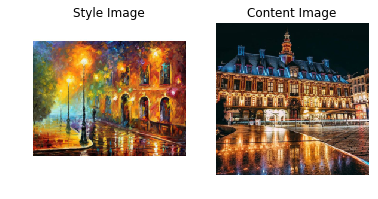

In [5]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)              # pause a bit so that plots are updated


plt.figure()
plt.subplot(121)
imshow(style_img, title='Style Image')
plt.subplot(122)

imshow(content_img, title='Content Image')


In [6]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


def gram_matrix(input_image):
    a, b, c, d = input_image.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input_image.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


    

In [7]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
# nous utilisons Features, pour enlever le classifieur. Ce qui nous interresse, c'est la sorties des couches convolutionnelles

# Nous instantions aussi un tensor avec les moyennes et les variances de chaques channels.
# Car VGG19 a été entrainé sur des images avec des channels normaliser avec ses variables.
# Cela permet à notre réseaux de ne pas être "perdu". 

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [8]:
def normalization_forward(mean, std, img):
    std = torch.tensor(mean).view(-1, 1, 1)    # change tensor's sizes with the '.view' method
    std = torch.tensor(std).view(-1, 1, 1) 
    return (img - mean) / std

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [9]:
# Take many layers for the style part make better results.
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

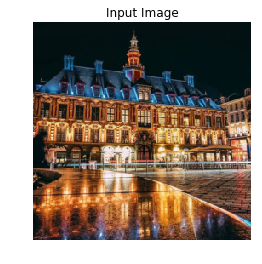

In [10]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [11]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
           # if run[0] % 50 == 0:
           #     print("run {}:".format(run))
            #    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
          #          style_score.item(), content_score.item()))
          #      print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


C:\Users\Henri Hoyez\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\Users\Henri Hoyez\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


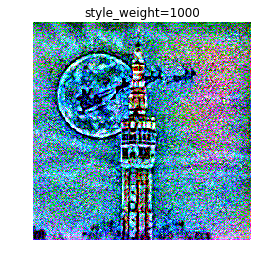

tensor([[[[0.2103, 0.0000, 0.0000,  ..., 0.0000, 0.7608, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2935, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.7655,  ..., 0.0000, 0.0000, 0.1173],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.8022, 0.3622, 1.0000],
          [0.3928, 0.0000, 0.0000,  ..., 0.6424, 0.1210, 1.0000],
          [0.4282, 0.4172, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[0.9966, 0.0000, 0.4043,  ..., 0.0231, 0.0000, 0.1808],
          [0.3999, 0.8986, 0.3487,  ..., 0.2396, 0.4365, 0.3206],
          [0.2818, 0.4696, 0.0000,  ..., 0.6086, 0.0517, 0.7550],
          ...,
          [0.4638, 0.0000, 0.0000,  ..., 0.5585, 0.8460, 0.6856],
          [0.0000, 0.0000, 0.1875,  ..., 0.8517, 1.0000, 0.1418],
          [0.0000, 0.0000, 0.0000,  ..., 0.0218, 0.0000, 1.0000]],

         [[0.0000, 0.0000, 0.7737,  ..., 1.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.7699,  ..., 0

In [17]:
style_img = image_loader('style/87153952_3930482080327099_3192798397727768576_n.jpg')
content_img = image_loader('imgs//imgs/13.jpg')
OUTPUT_FOLDER = "example/"

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img,content_img, style_weight=1000, content_weight=1)

imshow(output, title="style_weight={}".format(1000))
plt.savefig(OUTPUT_FOLDER + str(0)+ ".jpg")
plt.show()

print(output)

#style_weight=1000000

#for i in range(30):
#    intput_image = content_img.clone()
#    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                            content_img, style_img, intput_image, style_weight=1000000-1000+1000*i/30, content_weight=1)
#    plt.figure()
#    imshow(output, title="style_weight={}".format(1000000-1000+1000*i/30))
#    
#    plt.savefig(OUTPUT_FOLDER + str(i)+ ".jpg")
#
#    plt.ioff()
#    plt.show()

Building the style transfer model..
Optimizing..


C:\Users\Henri Hoyez\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\Users\Henri Hoyez\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


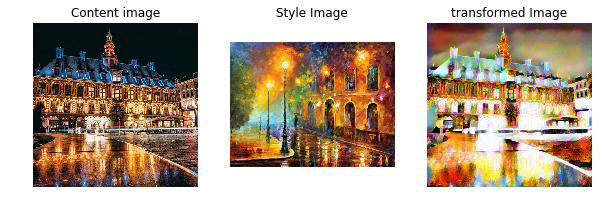

Building the style transfer model..
Optimizing..


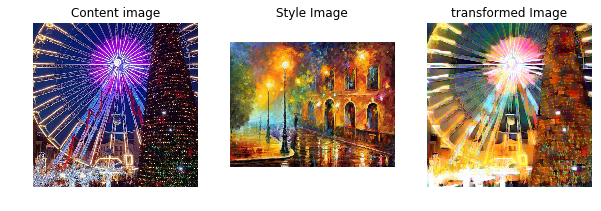

Building the style transfer model..
Optimizing..


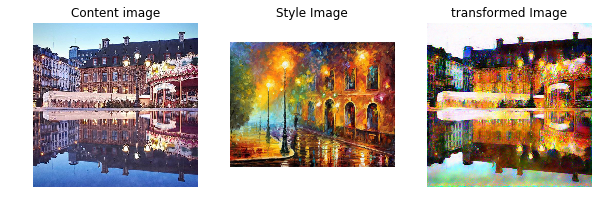

Building the style transfer model..
Optimizing..


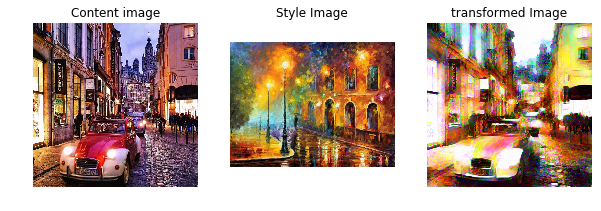

Building the style transfer model..
Optimizing..


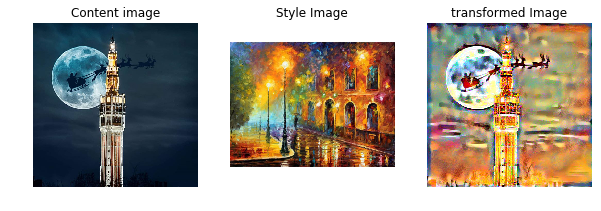

Building the style transfer model..
Optimizing..


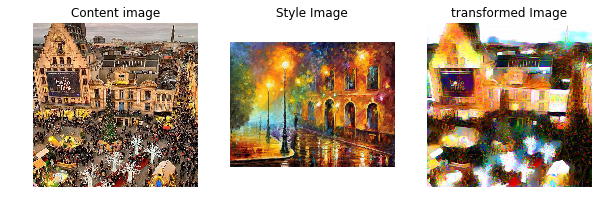

Building the style transfer model..
Optimizing..


In [ ]:
import os


style_img = image_loader( "style/Beau_paysage.jpg")
for content_root, _, content_files in os.walk("imgs/"):
    for content_file in content_files:
        cont_img = image_loader(content_root + os.sep + content_file)
        in_img = cont_img.clone()

        transformed_img = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                                        cont_img, style_img, in_img, content_weig)
        
        plt.figure(figsize=(10,10))
        plt.subplot(131)
        imshow(cont_img, title='Content image')
        plt.subplot(132)
        imshow(style_img, title='Style Image')
        plt.subplot(133)
        imshow(transformed_img, title='transformed Image')
        plt.show()






In [12]:
import numpy as np
import os

def grid_search(content_img_folder, style_img_folder):
    
    style_paths = [ f for f in os.listdir(style_img_folder) ]
    content_paths = [ f for f in os.listdir(content_img_folder) ]
    
    style_imgs = list()
    content_imgs = list()
    transformed_imgs = list()
    
    for style_path in style_paths:
        style_img = image_loader( style_img_folder + style_path)
        style_imgs.append(style_img)
        
        for i, content_path in enumerate(content_paths): 
            content_img = image_loader(content_img_folder + content_path)
            
            in_img = content_img.clone()

            transformed_img = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                                  content_img, style_img, in_img, style_weight=10000, content_weight=1)
            
            plt.figure(figsize=(10,10))
            plt.subplot(131)
            imshow(content_img, title='Content image')
            plt.subplot(132)
            imshow(style_img, title='Style Image')
            plt.subplot(133)
            imshow(transformed_img, title='transformed Image')
            plt.show()
                        
            if i >= len(content_imgs):
                content_imgs.append(content_img[0])
                transformed_imgs.append([transformed_img[0]])
            else:
                transformed_imgs[i].append(transformed_img[0])
                
            
    
    return style_imgs, content_imgs, transformed_imgs  
        
def plot_matrix(styles, contents, outputs):
    n_cols = len(styles) +1
    n_rows = len(contents) +1
    
    plt.figure(figsize=(20,18))
    
    for i in range(n_cols-1):
        plt.subplot2grid((n_rows, n_cols), (0, i+1))
        imshow(styles[i])
        
    for j in range(n_rows-1):
        plt.subplot2grid((n_rows, n_cols), (j+1, 0))
        imshow(contents[j])
       
    
    for i in range(n_cols -1):
        for j in range(n_rows - 1):
            plt.subplot2grid((n_rows, n_cols), (j+1, i+1))
            imshow(outputs[j][i])
            
    plt.savefig('test.png', dpi=400)
       
    
#style_imgs, content_imgs, transformed_imgs = grid_search("imgs/imgs/", "style/")

#plot_matrix(style_imgs, content_imgs, transformed_imgs)        
                
                

10
20
ffdgdsfg 20
fgdshtzf 10
0
1
2
3
4
5
6
7
8
9


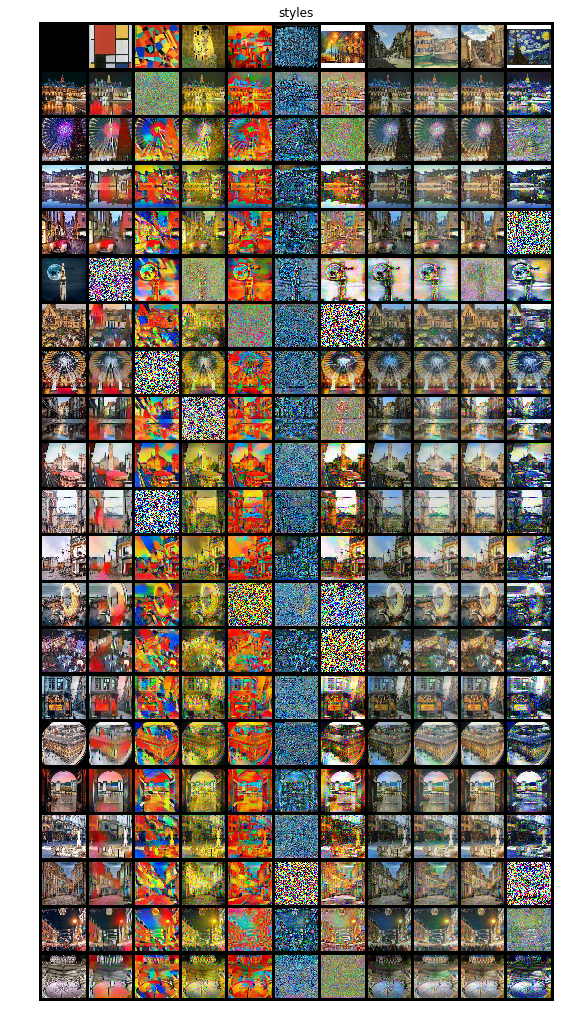

In [16]:
def style_matrix(style_imgs, content_imgs, transformed_imgs):
    n_style = len(style_imgs)
    n_cont = len(content_imgs)
    
    print(n_style)
    print(n_cont)
    print("ffdgdsfg",len(transformed_imgs))
    print("fgdshtzf", len(transformed_imgs[0]) )

    l = list()
    
    for i in range(n_cont+1):
        for j in range(n_style+1):
            if(i ==0 and j == 0):
                l.append(torch.zeros(3, 256, 256))
            
           
            if(i==0 and j > 0 and j < n_style+1):
               #styles headers
                print(j-1)
                l.append(style_imgs[j-1].squeeze().cpu())
                continue
           
            if(j==0 and i > 0 and i < n_cont+1):
               #content header
                l.append(content_imgs[i-1].cpu())
                continue

            if(i> 0 and j > 0):
                l.append( transformed_imgs[i-1][j-1].cpu() )
    
    images = torch.stack(l)
    grid_img = make_grid(images, nrow=n_style+1, padding=20)
    
    plt.figure(figsize=(20,18))
    plt.axis("off")
    plt.title("styles")
    plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
    plt.savefig("matrix_2.png", dpi=300)
    
    
#style_imgs, content_imgs, transformed_imgs = grid_search("imgs/imgs/", "style/")

style_matrix(style_imgs, content_imgs, transformed_imgs)

10
20
ffdgdsfg 20
fgdshtzf 10
0
1
2
3
4
5
6
7
8
9


AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

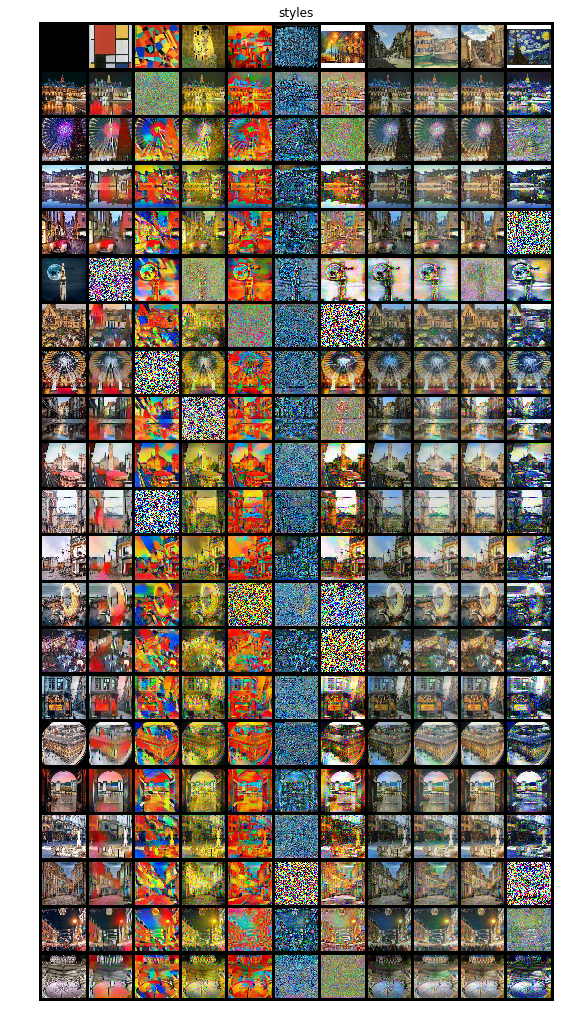